# Dependencies

In [1]:
from PIL import Image
import threading
import numpy as np
from matplotlib.pyplot import imshow
from io import StringIO, BytesIO
import random
from hashlib import sha256
from queue import Queue

# Helper Functions

* Getting the image pixel values

In [2]:
def generate_key(input_string):

  # Hash the input string using SHA-256
  hash = sha256(input_string.encode()).hexdigest()

  # Extract parts of the hash for different key components
  x0 = float.fromhex(hash[:8]) / 2**32
  y0 = float.fromhex(hash[8:16]) / 2**32

  # Use modulo to get a small integer seed
  seed = int(hash[16:], 16) % 2**16

  # Scale x0 and y0 to appropriate range
  x0 = min(x0, 1.5)
  y0 = min(y0, 1.5)

  return x0, y0, seed

In [3]:
def getImageMatrix(im):
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1],color

In [4]:
def dec(bitSequence):
    decimal = 0
    for bit in bitSequence:
        decimal = decimal * 2 + int(bit)
    return decimal

* Henon map generation(Transformation Matrix)

In [5]:
def genHenonMap(dimension, key):
    x = key[0]
    y = key[1]
    sequenceSize = dimension * dimension * 8
    bitSequence = []
    byteArray = []
    TImageMatrix = []
    for i in range(sequenceSize):
        xN = y + 1 - 1.4 * x*x
        yN = 0.3 * x

        x = xN
        y = yN

        if xN <= 0.4:
            bit = 0
        else:
            bit = 1

        try:
            bitSequence.append(bit)
        except:
            bitSequence = [bit]

        if i % 8 == 7:
            decimal = dec(bitSequence)
            try:
                byteArray.append(decimal)
            except:
                byteArray = [decimal]
            bitSequence = []

        byteArraySize = dimension*8
        if i % byteArraySize == byteArraySize-1:
            try:
                TImageMatrix.append(byteArray)
            except:
                TImageMatrix = [byteArray]
            byteArray = []
    return TImageMatrix

* Function to create a jumbled list

In [6]:
def jumble_list(n, seed):
    np.random.seed(seed)
    return (np.random.permutation(n)).tolist()

# Functions for Encryption

* Henon Encryption

In [7]:
def HenonEncryption(image,key):
    imageMatrix, dimensionX, dimensionY, color = getImageMatrix(image)
    transformationMatrix = genHenonMap(max(dimensionX,dimensionY), key)
    resultantMatrix = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            resultantMatrix.append(row)
        except:
            resultantMatrix = [row]
    if color:
      im = Image.new("RGB", (dimensionX, dimensionY))
    else:
      im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = resultantMatrix[x][y]
    return im

* Encrypted image to 3D cube

In [8]:
def convert_image_to_3d_cube(image):

  width, height = image.size
  cube = np.zeros((height, width, 3), dtype=np.uint8)

  for x in range(width):
    for y in range(height):
      pixel = image.getpixel((x, y))
      cube[y, x, :] = pixel

  return cube

* 3D Cube to binary file

In [9]:
def cube_to_binary(image_array,mode):
  sh=image_array.shape

  image_flat = image_array.flatten()    # Flattening the image to a 1D array
  shape_in_binary=(f"{sh[0]} {sh[1]} {sh[2]} {mode}\n".encode('utf-8'))
  binary_stream = BytesIO()
  binary_stream.write(shape_in_binary)
  binary_stream.write(image_flat.tobytes())
  binary_stream.seek(0)
  binary_string = StringIO()
  while True:
    data = binary_stream.read(2)
    if not data:
      break
    binary_string.write(''.join(format(byte, '08b') for byte in data))

  return binary_string.getvalue()

* Binary to RNA

In [10]:
def binary_to_RNA(binary_string):
  binary_to_dna = {'00000000': 'AAAA', '00000001': 'AAAG', '00000010': 'AAAC', '00000011': 'AAAU', '00000100': 'AAGA', '00000101': 'AAGG', '00000110': 'AAGC', '00000111': 'AAGU', '00001000': 'AACA', '00001001': 'AACG', '00001010': 'AACC', '00001011': 'AACU', '00001100': 'AAUA', '00001101': 'AAUG', '00001110': 'AAUC', '00001111': 'AAUU', '00010000': 'AGAA', '00010001': 'AGAG', '00010010': 'AGAC', '00010011': 'AGAU', '00010100': 'AGGA', '00010101': 'AGGG', '00010110': 'AGGC', '00010111': 'AGGU', '00011000': 'AGCA', '00011001': 'AGCG', '00011010': 'AGCC', '00011011': 'AGCU', '00011100': 'AGUA', '00011101': 'AGUG', '00011110': 'AGUC', '00011111': 'AGUU', '00100000': 'ACAA', '00100001': 'ACAG', '00100010': 'ACAC', '00100011': 'ACAU', '00100100': 'ACGA', '00100101': 'ACGG', '00100110': 'ACGC', '00100111': 'ACGU', '00101000': 'ACCA', '00101001': 'ACCG', '00101010': 'ACCC', '00101011': 'ACCU', '00101100': 'ACUA', '00101101': 'ACUG', '00101110': 'ACUC', '00101111': 'ACUU', '00110000': 'AUAA', '00110001': 'AUAG', '00110010': 'AUAC', '00110011': 'AUAU', '00110100': 'AUGA', '00110101': 'AUGG', '00110110': 'AUGC', '00110111': 'AUGU', '00111000': 'AUCA', '00111001': 'AUCG', '00111010': 'AUCC', '00111011': 'AUCU', '00111100': 'AUUA', '00111101': 'AUUG', '00111110': 'AUUC', '00111111': 'AUUU', '01000000': 'GAAA', '01000001': 'GAAG', '01000010': 'GAAC', '01000011': 'GAAU', '01000100': 'GAGA', '01000101': 'GAGG', '01000110': 'GAGC', '01000111': 'GAGU', '01001000': 'GACA', '01001001': 'GACG', '01001010': 'GACC', '01001011': 'GACU', '01001100': 'GAUA', '01001101': 'GAUG', '01001110': 'GAUC', '01001111': 'GAUU', '01010000': 'GGAA', '01010001': 'GGAG', '01010010': 'GGAC', '01010011': 'GGAU', '01010100': 'GGGA', '01010101': 'GGGG', '01010110': 'GGGC', '01010111': 'GGGU', '01011000': 'GGCA', '01011001': 'GGCG', '01011010': 'GGCC', '01011011': 'GGCU', '01011100': 'GGUA', '01011101': 'GGUG', '01011110': 'GGUC', '01011111': 'GGUU', '01100000': 'GCAA', '01100001': 'GCAG', '01100010': 'GCAC', '01100011': 'GCAU', '01100100': 'GCGA', '01100101': 'GCGG', '01100110': 'GCGC', '01100111': 'GCGU', '01101000': 'GCCA', '01101001': 'GCCG', '01101010': 'GCCC', '01101011': 'GCCU', '01101100': 'GCUA', '01101101': 'GCUG', '01101110': 'GCUC', '01101111': 'GCUU', '01110000': 'GUAA', '01110001': 'GUAG', '01110010': 'GUAC', '01110011': 'GUAU', '01110100': 'GUGA', '01110101': 'GUGG', '01110110': 'GUGC', '01110111': 'GUGU', '01111000': 'GUCA', '01111001': 'GUCG', '01111010': 'GUCC', '01111011': 'GUCU', '01111100': 'GUUA', '01111101': 'GUUG', '01111110': 'GUUC', '01111111': 'GUUU', '10000000': 'CAAA', '10000001': 'CAAG', '10000010': 'CAAC', '10000011': 'CAAU', '10000100': 'CAGA', '10000101': 'CAGG', '10000110': 'CAGC', '10000111': 'CAGU', '10001000': 'CACA', '10001001': 'CACG', '10001010': 'CACC', '10001011': 'CACU', '10001100': 'CAUA', '10001101': 'CAUG', '10001110': 'CAUC', '10001111': 'CAUU', '10010000': 'CGAA', '10010001': 'CGAG', '10010010': 'CGAC', '10010011': 'CGAU', '10010100': 'CGGA', '10010101': 'CGGG', '10010110': 'CGGC', '10010111': 'CGGU', '10011000': 'CGCA', '10011001': 'CGCG', '10011010': 'CGCC', '10011011': 'CGCU', '10011100': 'CGUA', '10011101': 'CGUG', '10011110': 'CGUC', '10011111': 'CGUU', '10100000': 'CCAA', '10100001': 'CCAG', '10100010': 'CCAC', '10100011': 'CCAU', '10100100': 'CCGA', '10100101': 'CCGG', '10100110': 'CCGC', '10100111': 'CCGU', '10101000': 'CCCA', '10101001': 'CCCG', '10101010': 'CCCC', '10101011': 'CCCU', '10101100': 'CCUA', '10101101': 'CCUG', '10101110': 'CCUC', '10101111': 'CCUU', '10110000': 'CUAA', '10110001': 'CUAG', '10110010': 'CUAC', '10110011': 'CUAU', '10110100': 'CUGA', '10110101': 'CUGG', '10110110': 'CUGC', '10110111': 'CUGU', '10111000': 'CUCA', '10111001': 'CUCG', '10111010': 'CUCC', '10111011': 'CUCU', '10111100': 'CUUA', '10111101': 'CUUG', '10111110': 'CUUC', '10111111': 'CUUU', '11000000': 'UAAA', '11000001': 'UAAG', '11000010': 'UAAC', '11000011': 'UAAU', '11000100': 'UAGA', '11000101': 'UAGG', '11000110': 'UAGC', '11000111': 'UAGU', '11001000': 'UACA', '11001001': 'UACG', '11001010': 'UACC', '11001011': 'UACU', '11001100': 'UAUA', '11001101': 'UAUG', '11001110': 'UAUC', '11001111': 'UAUU', '11010000': 'UGAA', '11010001': 'UGAG', '11010010': 'UGAC', '11010011': 'UGAU', '11010100': 'UGGA', '11010101': 'UGGG', '11010110': 'UGGC', '11010111': 'UGGU', '11011000': 'UGCA', '11011001': 'UGCG', '11011010': 'UGCC', '11011011': 'UGCU', '11011100': 'UGUA', '11011101': 'UGUG', '11011110': 'UGUC', '11011111': 'UGUU', '11100000': 'UCAA', '11100001': 'UCAG', '11100010': 'UCAC', '11100011': 'UCAU', '11100100': 'UCGA', '11100101': 'UCGG', '11100110': 'UCGC', '11100111': 'UCGU', '11101000': 'UCCA', '11101001': 'UCCG', '11101010': 'UCCC', '11101011': 'UCCU', '11101100': 'UCUA', '11101101': 'UCUG', '11101110': 'UCUC', '11101111': 'UCUU', '11110000': 'UUAA', '11110001': 'UUAG', '11110010': 'UUAC', '11110011': 'UUAU', '11110100': 'UUGA', '11110101': 'UUGG', '11110110': 'UUGC', '11110111': 'UUGU', '11111000': 'UUCA', '11111001': 'UUCG', '11111010': 'UUCC', '11111011': 'UUCU', '11111100': 'UUUA', '11111101': 'UUUG', '11111110': 'UUUC', '11111111': 'UUUU'}

  dna_string = StringIO()
  for i in range(0, len(binary_string), 8):
      dna_seq = binary_to_dna[binary_string[i:i+8]]
      dna_string.write(dna_seq)

  return dna_string.getvalue()

* Mutation (Jumbling the RNA sequence)

In [11]:
def mutate_rna(input_string, seed):
    string_len = len(input_string)
    number_sequence = jumble_list(string_len, seed)

    # Use the number sequence to create the jumbled string
    jumbled_string = ''.join(input_string[i] for i in number_sequence)

    return jumbled_string

# Functions for Decryption

* Fixation (Unjumbling)

In [12]:
def fixate_rna(jumbled_string, seed):
    string_len = len(jumbled_string)

    # Use the inverse of the number sequence to reconstruct the original string
    inverse_sequence = np.argsort(jumble_list(string_len, seed))
    original_string = ''.join(jumbled_string[i] for i in inverse_sequence)

    return original_string

* RNA to binary

In [13]:
def rna_to_binary(dna_sequence):
  dna_to_binary = {'AAAA': '00000000', 'AAAG': '00000001', 'AAAC': '00000010', 'AAAU': '00000011', 'AAGA': '00000100', 'AAGG': '00000101', 'AAGC': '00000110', 'AAGU': '00000111', 'AACA': '00001000', 'AACG': '00001001', 'AACC': '00001010', 'AACU': '00001011', 'AAUA': '00001100', 'AAUG': '00001101', 'AAUC': '00001110', 'AAUU': '00001111', 'AGAA': '00010000', 'AGAG': '00010001', 'AGAC': '00010010', 'AGAU': '00010011', 'AGGA': '00010100', 'AGGG': '00010101', 'AGGC': '00010110', 'AGGU': '00010111', 'AGCA': '00011000', 'AGCG': '00011001', 'AGCC': '00011010', 'AGCU': '00011011', 'AGUA': '00011100', 'AGUG': '00011101', 'AGUC': '00011110', 'AGUU': '00011111', 'ACAA': '00100000', 'ACAG': '00100001', 'ACAC': '00100010', 'ACAU': '00100011', 'ACGA': '00100100', 'ACGG': '00100101', 'ACGC': '00100110', 'ACGU': '00100111', 'ACCA': '00101000', 'ACCG': '00101001', 'ACCC': '00101010', 'ACCU': '00101011', 'ACUA': '00101100', 'ACUG': '00101101', 'ACUC': '00101110', 'ACUU': '00101111', 'AUAA': '00110000', 'AUAG': '00110001', 'AUAC': '00110010', 'AUAU': '00110011', 'AUGA': '00110100', 'AUGG': '00110101', 'AUGC': '00110110', 'AUGU': '00110111', 'AUCA': '00111000', 'AUCG': '00111001', 'AUCC': '00111010', 'AUCU': '00111011', 'AUUA': '00111100', 'AUUG': '00111101', 'AUUC': '00111110', 'AUUU': '00111111', 'GAAA': '01000000', 'GAAG': '01000001', 'GAAC': '01000010', 'GAAU': '01000011', 'GAGA': '01000100', 'GAGG': '01000101', 'GAGC': '01000110', 'GAGU': '01000111', 'GACA': '01001000', 'GACG': '01001001', 'GACC': '01001010', 'GACU': '01001011', 'GAUA': '01001100', 'GAUG': '01001101', 'GAUC': '01001110', 'GAUU': '01001111', 'GGAA': '01010000', 'GGAG': '01010001', 'GGAC': '01010010', 'GGAU': '01010011', 'GGGA': '01010100', 'GGGG': '01010101', 'GGGC': '01010110', 'GGGU': '01010111', 'GGCA': '01011000', 'GGCG': '01011001', 'GGCC': '01011010', 'GGCU': '01011011', 'GGUA': '01011100', 'GGUG': '01011101', 'GGUC': '01011110', 'GGUU': '01011111', 'GCAA': '01100000', 'GCAG': '01100001', 'GCAC': '01100010', 'GCAU': '01100011', 'GCGA': '01100100', 'GCGG': '01100101', 'GCGC': '01100110', 'GCGU': '01100111', 'GCCA': '01101000', 'GCCG': '01101001', 'GCCC': '01101010', 'GCCU': '01101011', 'GCUA': '01101100', 'GCUG': '01101101', 'GCUC': '01101110', 'GCUU': '01101111', 'GUAA': '01110000', 'GUAG': '01110001', 'GUAC': '01110010', 'GUAU': '01110011', 'GUGA': '01110100', 'GUGG': '01110101', 'GUGC': '01110110', 'GUGU': '01110111', 'GUCA': '01111000', 'GUCG': '01111001', 'GUCC': '01111010', 'GUCU': '01111011', 'GUUA': '01111100', 'GUUG': '01111101', 'GUUC': '01111110', 'GUUU': '01111111', 'CAAA': '10000000', 'CAAG': '10000001', 'CAAC': '10000010', 'CAAU': '10000011', 'CAGA': '10000100', 'CAGG': '10000101', 'CAGC': '10000110', 'CAGU': '10000111', 'CACA': '10001000', 'CACG': '10001001', 'CACC': '10001010', 'CACU': '10001011', 'CAUA': '10001100', 'CAUG': '10001101', 'CAUC': '10001110', 'CAUU': '10001111', 'CGAA': '10010000', 'CGAG': '10010001', 'CGAC': '10010010', 'CGAU': '10010011', 'CGGA': '10010100', 'CGGG': '10010101', 'CGGC': '10010110', 'CGGU': '10010111', 'CGCA': '10011000', 'CGCG': '10011001', 'CGCC': '10011010', 'CGCU': '10011011', 'CGUA': '10011100', 'CGUG': '10011101', 'CGUC': '10011110', 'CGUU': '10011111', 'CCAA': '10100000', 'CCAG': '10100001', 'CCAC': '10100010', 'CCAU': '10100011', 'CCGA': '10100100', 'CCGG': '10100101', 'CCGC': '10100110', 'CCGU': '10100111', 'CCCA': '10101000', 'CCCG': '10101001', 'CCCC': '10101010', 'CCCU': '10101011', 'CCUA': '10101100', 'CCUG': '10101101', 'CCUC': '10101110', 'CCUU': '10101111', 'CUAA': '10110000', 'CUAG': '10110001', 'CUAC': '10110010', 'CUAU': '10110011', 'CUGA': '10110100', 'CUGG': '10110101', 'CUGC': '10110110', 'CUGU': '10110111', 'CUCA': '10111000', 'CUCG': '10111001', 'CUCC': '10111010', 'CUCU': '10111011', 'CUUA': '10111100', 'CUUG': '10111101', 'CUUC': '10111110', 'CUUU': '10111111', 'UAAA': '11000000', 'UAAG': '11000001', 'UAAC': '11000010', 'UAAU': '11000011', 'UAGA': '11000100', 'UAGG': '11000101', 'UAGC': '11000110', 'UAGU': '11000111', 'UACA': '11001000', 'UACG': '11001001', 'UACC': '11001010', 'UACU': '11001011', 'UAUA': '11001100', 'UAUG': '11001101', 'UAUC': '11001110', 'UAUU': '11001111', 'UGAA': '11010000', 'UGAG': '11010001', 'UGAC': '11010010', 'UGAU': '11010011', 'UGGA': '11010100', 'UGGG': '11010101', 'UGGC': '11010110', 'UGGU': '11010111', 'UGCA': '11011000', 'UGCG': '11011001', 'UGCC': '11011010', 'UGCU': '11011011', 'UGUA': '11011100', 'UGUG': '11011101', 'UGUC': '11011110', 'UGUU': '11011111', 'UCAA': '11100000', 'UCAG': '11100001', 'UCAC': '11100010', 'UCAU': '11100011', 'UCGA': '11100100', 'UCGG': '11100101', 'UCGC': '11100110', 'UCGU': '11100111', 'UCCA': '11101000', 'UCCG': '11101001', 'UCCC': '11101010', 'UCCU': '11101011', 'UCUA': '11101100', 'UCUG': '11101101', 'UCUC': '11101110', 'UCUU': '11101111', 'UUAA': '11110000', 'UUAG': '11110001', 'UUAC': '11110010', 'UUAU': '11110011', 'UUGA': '11110100', 'UUGG': '11110101', 'UUGC': '11110110', 'UUGU': '11110111', 'UUCA': '11111000', 'UUCG': '11111001', 'UUCC': '11111010', 'UUCU': '11111011', 'UUUA': '11111100', 'UUUG': '11111101', 'UUUC': '11111110', 'UUUU': '11111111'}

  binary_string = StringIO()
  l = len(dna_sequence)
  for i in range(0, l, 4):
      sequence = dna_sequence[i:i + 4]
      binary_string.write(dna_to_binary.get(sequence))

  return binary_string.getvalue()


* Binary to 3D cube

In [14]:
def binary_to_cube(binary_string):
    byte_stream = BytesIO()
    for i in range(0, len(binary_string), 8):
        byte = int(binary_string[i:i+8], 2)
        byte_stream.write(bytes([byte]))

    byte_stream.seek(0)

    # Extract the string
    shape = ""
    while True:
        char = byte_stream.read(1).decode('utf-8')
        if char == '\n':
            break
        shape += char
    image_info = shape.split(' ')
    h, w, c = int(image_info[0]), int(image_info[1]), int(image_info[2])
    mode = image_info[3]
    # Extract the array
    array_data = byte_stream.read()
    flat_array = np.frombuffer(array_data, dtype=np.uint8)
    cube = flat_array.reshape(h,w,c)

    return cube, mode


* 3D Cube to encrypted image

In [15]:
def convert_3d_cube_to_image(cube):
  return Image.fromarray(cube, mode="RGB")

* Henon Decryption

In [16]:
def HenonDecryption(imageEnc, key):
    imageMatrix, dimensionX, dimensionY, color = getImageMatrix(imageEnc)
    transformationMatrix = genHenonMap(max(dimensionX,dimensionY), key)
    henonDecryptedImage = []
    for i in range(dimensionX):
        row = []
        for j in range(dimensionY):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            henonDecryptedImage.append(row)
        except:
            henonDecryptedImage = [row]
    if color:
        im = Image.new("RGB", (dimensionX, dimensionY))
    else:
        im = Image.new("L", (dimensionX, dimensionY)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimensionX):
        for y in range(dimensionY):
            pix[x, y] = henonDecryptedImage[x][y]
    return im

# Multiple Image Encryption(threaded version)

In [ ]:
def process_image(image_path, shared_key, output_queue):
    try:
        mode = image_path.split('.')[1]
        im = Image.open(image_path, 'r')

        encrypted_image = HenonEncryption(im, shared_key)
        cube = convert_image_to_3d_cube(encrypted_image)
        binary_image = cube_to_binary(cube, mode)
        rna_image = binary_to_RNA(binary_image)

        output_queue.put(rna_image)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def main(image_paths, shared_key):
    threads = []
    output_queue = Queue()

    for image_path in image_paths:
        thread = threading.Thread(target=process_image, args=(image_path, shared_key, output_queue))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    rna_sequences = []
    lengths = []
    while not output_queue.empty():
        rna = output_queue.get()
        rna_sequences.append(rna)
        lengths.append(len(rna))

    return rna_sequences, lengths

# Example usage
image_paths = ['/content/Doggy.jpeg', '/content/fingerprint.webp', '/content/plant.jpeg']
seed_string = 'fc,.8&^$uiwbuv684616.[;4;3.6,/;9]'
initial_x_henon_map, initial_y_henon_map, seed_for_jumbling = generate_key(seed_string)
shared_key = (initial_x_henon_map, initial_y_henon_map, seed_for_jumbling)
rna_sequences, lengths = main(image_paths, shared_key)


combined_rna = '\n'.join(sequence for sequence in rna_sequences)
print(len(combined_rna.split('\n')),"com")
mutated_sequence = mutate_rna(combined_rna, shared_key[2])
print(len(mutated_sequence.split('\n')),"mut")

3 com
3 mut


In [ ]:
print(lengths)

[337500, 603960, 4464060]


In [ ]:
len(mutated_sequence)

5405522

In [ ]:
with open("RNA.txt","w") as f:
  f.write(mutated_sequence)

# Multiple Image Decryption (threaded version)

In [ ]:
with open("RNA.txt","r") as f:
  mutated_sequence_rec=f.read()

In [ ]:
s = mutated_sequence.split("\n")
for i in s:
  print(len(i))

379082
2415744
2610694


In [ ]:
def process_rna(rna_sequence, shared_key, output_queue):
    try:
        out_binary_image = rna_to_binary(rna_sequence)
        out_cube, mode = binary_to_cube(out_binary_image)
        out_enc_image = convert_3d_cube_to_image(out_cube)
        final_out_image = HenonDecryption(out_enc_image, shared_key)

        output_queue.put(final_out_image)
    except Exception as e:
        print(f"Error processing RNA sequence: {e}")

def main(rna_sequences, shared_key):
    threads = []
    output_queue = Queue()

    for rna_sequence in rna_sequences:
        thread = threading.Thread(target=process_rna, args=(rna_sequence, shared_key, output_queue))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    decrypted_images = []
    while not output_queue.empty():
        decrypted_images.append(output_queue.get())

    return decrypted_images

# Example usage
# rna_sequences = ["rna_sequence_1", "rna_sequence_2", "rna_sequence_3"]
seed_string = 'fc,.8&^$uiwbuv684616.[;4;3.6,/;9]'
initial_x_henon_map_dec, initial_y_henon_map_dec, seed_for_unjumbling = generate_key(seed_string)
shared_key = (initial_x_henon_map_dec, initial_y_henon_map_dec, seed_for_unjumbling)
rna_sequences = list(fixate_rna(mutated_sequence_rec,shared_key[2]).split("\n"))
decrypted_images = main(rna_sequences, shared_key)

# Now, decrypted_images contains the decrypted images processed by each thread


In [ ]:
for i in rna_sequences:
  print(len(i))

337500
603960
4464060


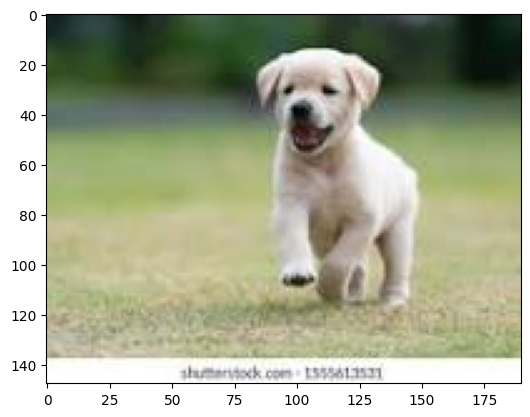

In [ ]:
imshow(np.asarray(decrypted_images[0]))

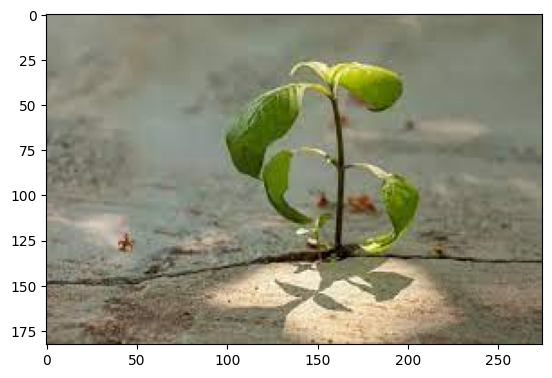

In [ ]:
imshow(np.asarray(decrypted_images[1]))

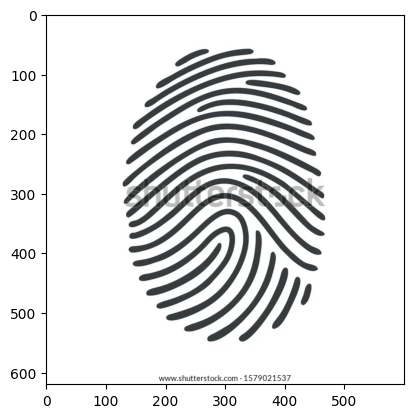

In [ ]:
imshow(np.asarray(decrypted_images[2]))